# Instruction
I have a typical project of predicting the NYC uber/lyft trip demand. The dataset is available from Jan2022 to March 2023. The area is already divided into different locations. and I want the predicted demand for each location every 15 mins
## Problem statment
The goal of this project is to predict the demand for Uber/Lyft trips in different locations of NYC every 15 minutes, using a dataset spanning from January 2022 to March 2023. The dataset includes information such as the dispatching base number, pickup datetime, drop-off datetime, pickup location ID, drop-off location ID, SR_Flag, and affiliated base number 

In [40]:
import pandas as pd
import glob
import tqdm
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from dateutil.relativedelta import relativedelta
import numpy as np
from pmdarima import auto_arima

import pandas as pd
import numpy as np
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

# Create subplots with one trace per page using go object of plotly.graph_objs module 
import plotly.graph_objs as go

# Import TimeSeries class from darts library
import darts    
from darts import TimeSeries


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [47]:
# Uses the glob.glob function to retrieve a list of file paths that match the specified 
# pattern 'Datasets/fhv_tripdata_2022-2023_in_csv/*.csv'. 
# This pattern is used to find all CSV files in the given directory.
data_list_path = glob.glob('Datasets/fhv_tripdata_2022-2023_in_csv/*.csv')

# Initializes an empty list called list_df to store the DataFrames.
list_df = []
# terates over each file path in data_list_path
for path in data_list_path:
    print(path)
    # Step 1: Preprocess the Dataset
    # inside the loop, it reads each CSV file using pd.read_csv and assigns it to the variable df.
    df = pd.read_csv(path)
    # Appends the DataFrame to the list_df list.
    list_df.append(df)
    
# After the loop, it concatenates all the DataFrames in list_df into a single DataFrame using pd.concat. 
# The concatenated DataFrame is assigned to the variable df
df =  pd.concat(list_df)

# Specifies a list of column names ('pickup_datetime' and 'PUlocationID') 
# in interested_features that you are interested in keeping
interested_features = ['pickup_datetime','PUlocationID']
# Updates df to contain only the columns specified in interested_features using indexing.
df = df[interested_features]


# Summary :
# Overall, this code reads multiple CSV files from the specified directory, 
# concatenates them into a single DataFrame, and then selects and keeps only the columns specified in interested_features

Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-09.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-02.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-04.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-07.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-01.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-06.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-08.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2023-03.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-11.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-12.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2023-02.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-03.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2023-01.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-05.csv
Datasets/fhv_tripdata_2022-2023_in_csv/fhv_tripdata_2022-10.csv


In [48]:
# The code imports the necessary libraries:
import pandas as pd
import pmdarima as pm
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

# Prints the number of rows in the DataFrame df before removing rows with NaN values
# This line uses the .shape[0] attribute of a DataFrame to retrieve the number of rows.
print('Number of Rows Before Removing NaN:', df.shape[0])
# Removes rows with NaN values from the DataFrame df and assigns the result to removed_nan_df:
removed_nan_df = df.dropna()
#The .dropna() method is used to remove rows containing any NaN values. 
#The resulting DataFrame with NaN rows removed is assigned to removed_nan_df/
print('Number of Rows After Removing NaN:', removed_nan_df.shape[0])


Number of Rows Before Removing NaN: 17712727
Number of Rows After Removing NaN: 4164902


In [49]:
# Retrieves unique values from the 'PUlocationID' column in the 
# DataFrame removed_nan_df and converts them to a list:
location_ids = removed_nan_df['PUlocationID'].unique().tolist()

# Initializes a loop counter variable:
loop_count = 0
# Iterates over each unique location ID in location_ids:
for lc_id in location_ids:
    # Prints the current location ID:

    print('Location ID:', lc_id)
    # Filters removed_nan_df to create a subset DataFrame (df_subset)
    # containing rows with a specific 'PUlocationID
    df_subset = removed_nan_df[removed_nan_df['PUlocationID'] == lc_id]
    # Converts the 'pickup_datetime' column in df_subset to datetime format using pd.to_datetime
    
    
    
    df_subset['pickup_datetime'] = pd.to_datetime(df_subset['pickup_datetime'])
    
    # Sorts df_subset based on the 'pickup_datetime' column:
    df_subset = df_subset.sort_values('pickup_datetime')
    
    # Sets the 'pickup_datetime' column as the index of df_subset:
    df_subset = df_subset.set_index('pickup_datetime')
    
    
    # Resamples df_subset at a frequency of 1 hour ('1H') and counts the number of occurrences per hour:
    
    df_subset= df_subset['PUlocationID'].resample('1H').count()
    
    display(df_subset)
    
    # Resets the index of df_subset to convert the index (time) back into a column:
    df_subset = df_subset.reset_index()
    # Split data into training and testing sets
    # Determines the train-test split based on the length of df_subset,
    # with 95% of the data used for training and the remaining 5% for testing:
    train_size = int(len(df_subset) * 0.95)
    train_data = df_subset[:train_size]
    test_data = df_subset[train_size:]

    # Perform auto ARIMA on training data
    # Uses the pm.auto_arima function from the pmdarima 
    # library to automatically determine the best ARIMA model for the training data:
    # seasonal_order = (range(0, 3), range(0, 2), range(0, 3), [4,6,9,12 ])
    model = pm.auto_arima(train_data['PUlocationID'], 
                            seasonal=True, 
                            trace=True
                            # m=12, 
                            # start_p=0, start_q=0, max_p=3, max_q=3,
                            # start_P=0, start_Q=0, max_P=3, max_Q=3,
                            # d=None, D=None,
                            # error_action='ignore', suppress_warnings=True,
                            # stepwise=True, random_state=42,
                            # seasonal_order=seasonal_order
                            )
    print(model.summary())
    # Generate predictions
    # Generates predictions (forecast) using the ARIMA model and
    # calculates the confidence interval (conf_int) for the length of the test data
    forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

     # Create a dataframe for predictions and actual values
    result_df = pd.DataFrame({
        'pickup_datetime': test_data['pickup_datetime'],
        'Actual': test_data['PUlocationID'],
        'Forecast': forecast
    })
    # Save the dataframe to a CSV file
    filename = f"arima-results/{lc_id}_data.csv"
    result_df.to_csv(filename, index=False)

    # Plotting
    # Creates a Plotly figure (fig) and adds traces for the training data, testing data, and ARIMA forecast:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_data.index, y=train_data['PUlocationID'], mode='lines+markers', name='Training Data'))
    fig.add_trace(go.Scatter(x=test_data.index, y=test_data['PUlocationID'], mode='lines+markers', name='Testing Data'))
    fig.add_trace(go.Scatter(x=test_data.index, y=forecast, mode='lines+markers', name='ARIMA Forecast'))
    # Updates the layout of the figure with a title and axis labels:

    fig.update_layout(title=f'PickLocation ID: {lc_id}', xaxis_title='Time', yaxis_title='Number Drives')
    # Displays the figure:
    fig.show()
    break
    loop_count +=1
    # Checks if the loop count is greater than 5 and breaks the loop if so:
    if loop_count >1:
        break

# Summary
# if you want to code for each location then remove if condition of loop counter
# Overall, this code performs time series analysis and forecasting for each location ID, allowing for an understanding 
# of the patterns and trends in the dataset at different locations.

Location ID: 12.0


pickup_datetime
2022-01-02 16:00:00    1
2022-01-02 17:00:00    0
2022-01-02 18:00:00    0
2022-01-02 19:00:00    0
2022-01-02 20:00:00    0
                      ..
2023-03-30 17:00:00    0
2023-03-30 18:00:00    1
2023-03-30 19:00:00    0
2023-03-30 20:00:00    1
2023-03-30 21:00:00    1
Freq: H, Name: PUlocationID, Length: 10854, dtype: int64

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11849.933, Time=31.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-11825.381, Time=6.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-11844.742, Time=13.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-11843.762, Time=6.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11650.357, Time=0.73 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-11854.674, Time=28.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-11847.957, Time=9.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-11846.164, Time=8.31 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-11844.097, Time=21.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-11847.073, Time=9.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-11854.373, Time=28.28 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-11853.703, Time=60.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=5.06 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 228.299 sec

In [28]:

def plot(df,x_feature_name,y_feature_name,title):
    """
    This function takes two dataframes as input and plots the number of calls per day and per week.

    Args:
    daily_df (pandas.DataFrame): A dataframe containing daily call data.
    weekly_df (pandas.DataFrame): A dataframe containing weekly call data.

    Returns:
    None
    """

    # Create a subplot with two rows and one column
    # fig = make_subplots(rows=2, cols=1)
    fig = go.Figure()
    # Add a trace for daily calls
    fig.add_trace(
        go.Scatter(
            x=df[x_feature_name],
            y=df[y_feature_name],
            name=y_feature_name,
            mode='lines+markers'
        ))

 

    # Update xaxis properties
    fig.update_xaxes(title_text='Date')

    # Update yaxis properties
    fig.update_yaxes(title_text=y_feature_name)

    # Update title and height
    fig.update_layout(
        title=f'{title}',
        height=500,
        width=1200
    )

    # Show the plot
    fig.show()

    # Write the plot to an HTML file
    # fig.write_html(f'Visualization/btc.html')
    

def train_test_predicted_plot(df_train,
                              df_test,
                              x_feature ,
                              y_feature,
                              predicted, 
                              model_name):
    """
    Plots the training data, actual values, and forecasted values using Plotly.

    Args:
        train (pd.Series): The training data.
        test (pd.Series): The actual values.
        predicted (pd.Series): The forecasted values.
        model_name (str): The name of the forecasting model.

    Returns:
        None
    """
  

   
    # Create a subplot with two rows and one column
    fig = go.Figure()

    fig.add_trace(
    go.Scatter(
        x=df_train[x_feature],
        y=df_train[y_feature],
        name='Training Data',
        mode='lines+markers'
    ))

    # Add a trace for actual values
    fig.add_trace(
        go.Scatter(
            x=df_test[x_feature],
            y=df_test[y_feature],
            name='Actual Values',
            mode='lines+markers'
        )
    )

    # Add a trace for forecasted values
    fig.add_trace(
        go.Scatter(
            x=df_test[x_feature],
            y=forecast[y_feature],
            name=f'{model_name}',
            mode='lines+markers'
        )
    )

    # Update xaxis properties
    fig.update_xaxes(title_text='Time')

    # Update yaxis properties
    fig.update_yaxes(title_text=y_feature)

    # Update title and height
    fig.update_layout(
        title=f'Forecasting using {model_name}',
        height=500,
        width=1500
    )

    # Save the plot as an HTML file
    fig.show()

In [15]:
location_ids

[]

In [17]:
location_ids = removed_nan_df['PUlocationID'].unique().tolist()

# Initializes a loop counter variable:
loop_count = 0
# Iterates over each unique location ID in location_ids:
for lc_id in location_ids:
    # Prints the current location ID:

    print('Location ID:', lc_id)
    # Filters removed_nan_df to create a subset DataFrame (df_subset)
    # containing rows with a specific 'PUlocationID
    df_subset = removed_nan_df[removed_nan_df['PUlocationID'] == lc_id]
    # Converts the 'pickup_datetime' column in df_subset to datetime format using pd.to_datetime
    df_subset['pickup_datetime'] = pd.to_datetime(df_subset['pickup_datetime'])
    # Sorts df_subset based on the 'pickup_datetime' column:
    df_subset = df_subset.sort_values('pickup_datetime')
    # Sets the 'pickup_datetime' column as the index of df_subset:
    df_subset = df_subset.set_index('pickup_datetime')
    # Resamples df_subset at a frequency of 1 hour ('1H') and counts the number of occurrences per hour:
    df_subset = df_subset['PUlocationID'].resample('1H').count()
    # Resets the index of df_subset to convert the index (time) back into a column:
    df_subset = df_subset.reset_index()
    break

Location ID: 12.0


In [18]:
single_location_df = df_subset

display(single_location_df)

x_feature_name ='pickup_datetime' 
y_feature_name='PUlocationID'
title = 'Location ID 12.0'
plot(single_location_df,x_feature_name,y_feature_name,title)




pickup_datetime  PUlocationID
0     2022-01-02 16:00:00             1
1     2022-01-02 17:00:00             0
2     2022-01-02 18:00:00             0
3     2022-01-02 19:00:00             0
4     2022-01-02 20:00:00             0
...                   ...           ...
10849 2023-03-30 17:00:00             0
10850 2023-03-30 18:00:00             1
10851 2023-03-30 19:00:00             0
10852 2023-03-30 20:00:00             1
10853 2023-03-30 21:00:00             1

[10854 rows x 2 columns]

In [21]:

def adfuller_test(values):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

adfuller_test(single_location_df['PUlocationID'])


ADF Test Statistic : -48.45579136522705
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 10850
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [23]:
# converting dataframe to time series object to make the data to fit the model 
time_series_hourly = TimeSeries.from_dataframe(single_location_df,'pickup_datetime','PUlocationID',freq='1H' ,fill_missing_dates=True,fillna_value=True)


# splting the datsets 98% for training the mode and 2% for testing the model
train , test = time_series_hourly.split_after(0.98)

# print the shape of train and test data
print('Shape of train set : ',train.pd_dataframe().shape)
print('Shape of test set : ',test.pd_dataframe().shape)
Horizan = test.pd_dataframe().shape[0]



Shape of train set :  (10636, 1)
Shape of test set :  (218, 1)


In [24]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(time_series_hourly, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 4.
There is seasonality of order 6.
There is seasonality of order 9.
There is seasonality of order 20.


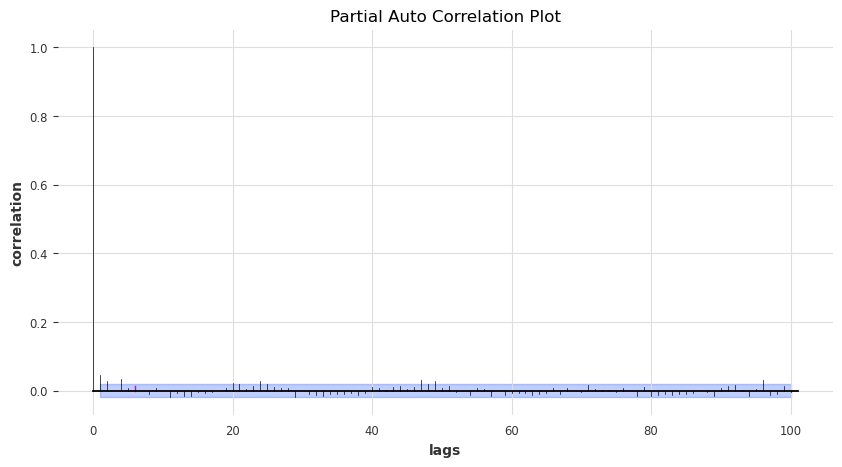

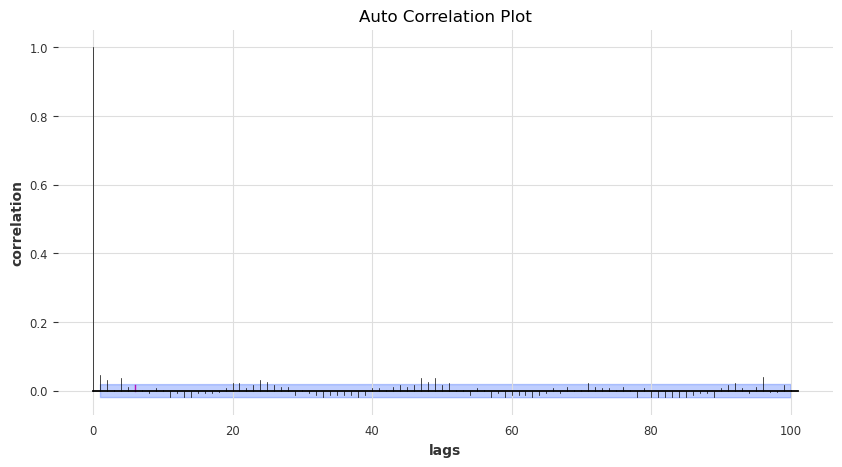

In [26]:

from darts.utils.statistics import plot_acf,plot_pacf


from darts.utils.statistics import plot_acf,plot_pacf
plot_pacf(time_series_hourly, m=6, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)

plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Partial Auto Correlation Plot')
plt.show()

plot_acf(time_series_hourly, m=6, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)
plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Auto Correlation Plot')
plt.show()

In [36]:

from darts.models.forecasting.arima import ARIMA
# these parameters has been found using correlation plot and partial correlation plots
# i added the description there please read that paragraph # and we can also test 
# other order by try and test method
arima_model =  ARIMA(p= 3 , #, for Auto regressive parameter
                     d=0  , # for difference to make the data is statioanry
                     q = 2 ,  # for the moving Average,
                     seasonal_order=(3, 0, 2, 6)
                     )
arima_model.fit(train)
predictions = arima_model.predict(Horizan)

# Convert train_series into a pandas dataframe and reset index
df_train = train.pd_dataframe().reset_index()

# Convert test_series into a pandas dataframe and reset index
df_test = test.pd_dataframe().reset_index()

# Convert prediction into a pandas dataframe and reset index
forecast = predictions.pd_dataframe().reset_index()


x_feature ='pickup_datetime' 
y_feature='PUlocationID'
model_name = 'Arima Prediction'
train_test_predicted_plot(df_train,df_test,x_feature,y_feature,forecast,'ARTIMA-Prediction')

In [35]:
arima_model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10636
Model:                 ARIMA(3, 0, 2)   Log Likelihood                6121.358
Date:                Tue, 06 Jun 2023   AIC                         -12228.716
Time:                        18:59:44   BIC                         -12177.812
Sample:                             0   HQIC                        -12211.538
                              - 10636                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.005      3.335      0.001       0.007       0.028
ar.L1          0.0479      0.369      0.130      0.897      -0.676       0.771
ar.L2          0.6567      0.182      3.601      0.000       0.299       1.014
ar.L3         -0.0349      0.026     -1.332      0.183      -0.086       0.016
ma.L1         -0.0046      0.370     -0.012      0.990      -0.730       0.720
ma.L2         -0.6284      0.195     -3.217      0.001      -1.011      -0.246
sigma2         0.0185      0.000    114.936      0.000       0.018       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2042141.78
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             7.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        69.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""